# Evaluating the Agents

First, a simulator to compare the agents must be built:

In [102]:
from Blackjack.Round import Round
from Blackjack.Dealer import Dealer
from Blackjack.Action import Action
from Blackjack.Agent.MonteCarloOnPolicyAgent import MonteCarloOnPolicyAgent
from Blackjack.Agent.SarsaOnPolicyAgent import SarsaOnPolicyAgent
from Blackjack.Agent.Agent import Agent
from Blackjack.Action import Action

class AgentSimulator():
    def __init__(self, agent: Agent):
        self.agent = agent
        self.round = None

    def play_round(self):
        self.round = Round()

        action = Action.HIT

        while action == Action.HIT and self.round.get_terminal_state() is None and self.round.get_sum_for_player(True) [0] != 21:
            action = self.agent.get_policy(self.round.get_agent_state())

            if action == Action.HIT:
                self.round.hit()
            elif action == Action.STAND:
                self.round.stand()

            if isinstance(self.agent, SarsaOnPolicyAgent): # agents which update after each action (SARSA)
                self.agent.update_agent(self.round, self.agent.get_policy(self.round.get_agent_state()), self.round.get_terminal_state())

        # loss, agent sum went over 21
        if self.round.get_terminal_state() is not None: 
            # agents which update at the end of the episode (Monte Carlo) need to be updated
            # note that agents which update after each action (SARSA) already updated after applying the action resulting in a loss
            if isinstance(self.agent, MonteCarloOnPolicyAgent):
                self.agent.update_agent(self.round)

            self.agent.end_episode()

            return self.round.get_terminal_state(True)
        
        # switching turns
        if self.round.get_sum_for_player(True) [0] == 21:
            self.round.stand() # change turn to dealer

        dealer = Dealer()

        while dealer.get_policy(self.round.get_sum_for_player(False) [0]) == Action.HIT and self.round.get_terminal_state() == None:
            self.round.hit()

        # updating agents
        if isinstance(self.agent, MonteCarloOnPolicyAgent):
            self.agent.update_agent(self.round)
        elif isinstance(self.agent, SarsaOnPolicyAgent):
            self.agent.update_agent(self.round, Action.STAND, self.round.get_terminal_state(True))

        self.agent.end_episode()

        return self.round.get_terminal_state(True)

    def simulate_games(self, num_games):
        results = []

        for _ in range(int(num_games / 1000)):
            results.append({
                "wins": 0,
                "losses": 0,
                "draws": 0
            })

            for _ in range(1000):
                result = self.play_round()

                if result == 1:
                    results [-1] ["wins"] += 1
                elif result == -1:
                    results [-1] ["losses"] += 1
                else:
                    results [-1] ["draws"] += 1

        return results

Defining functions to properly display the agents' results:

In [103]:
import matplotlib.pyplot as plt

def plot_results(results, title):
    x = list(range(0, len(results) * 1000, 1000))

    wins = [result ["wins"] for result in results]
    losses = [result ["losses"] for result in results]
    draws = [result ["draws"] for result in results]

    plt.plot(x, wins, label = "Wins", color = "#56e364")
    plt.plot(x, losses, label = "Losses", color = "#d12e2e")
    plt.plot(x, draws, label = "Draws", color = "#2e36d1")

    plt.xlabel("Episode Count")
    plt.ylabel("No. of Games")

    plt.title(title)
    plt.grid()
    plt.legend(loc = "lower right")

In [104]:
def plot_state_action_counts(state_action_counts, title):
    # TODO: no idea how to show the states in a readable way

    # get top 50 most common state-action pairs
    # state_action_counts = dict(sorted(state_action_counts.items(), key = lambda x: x [1], reverse = True) [:50])

    labels = []
    counts = []

    for state_action, count in state_action_counts.items():
        state_dict = dict(state_action [0])

        label = f"sum {state_dict ['agent_sum']} card {state_dict ['dealer_card']} uses_ace {state_dict ['uses_ace']} {state_action [1]}"
        labels.append(label)

        counts.append(count)

    sorted_labels_counts = sorted(zip(labels, counts), key = lambda x: x [1], reverse = True)
    sorted_labels, sorted_counts = zip(*sorted_labels_counts)

    plt.bar(sorted_labels, sorted_counts, color = "#2e36d1")

    plt.ylabel("State-Action Count")

    plt.title(title)

In [105]:
def generate_strategy_table(agent: Agent, uses_ace):
    strategy_table = []

    dealer_cards = range(2, 12)
    player_sums = list(range(12, 21))

    for player_sum in player_sums:
        row = [player_sum]

        for dealer_card in dealer_cards:
            state = {
                "agent_sum": player_sum,
                "dealer_card": dealer_card,
                "uses_ace": uses_ace
            }

            action = agent.get_policy(state)

            if action == Action.HIT:
                row.append("H")
            elif action == Action.STAND:
                row.append("S")

        strategy_table.append(row)

    return strategy_table

In [106]:
def plot_total_state_action_counts(agents_n_counts, agents_descriptions, title):
    sums = []

    for agent_n_counts in agents_n_counts:
        sum = 0

        for count in agent_n_counts.values():
            sum += count

        sums.append(sum)

    plt.bar(agents_descriptions, sums, color = "blue")

    plt.ylabel("Total State-Action Count")
    plt.title(title)

Evaluating the Monte-Carlo On-Policy Agents:

In [ ]:
mcop_agent_1 = MonteCarloOnPolicyAgent(True, 1) # exploring starts, epsilon is 1/k
mcop_agent_1_simulator = AgentSimulator(mcop_agent_1)
mcop_agent_1_results = mcop_agent_1_simulator.simulate_games(100000)

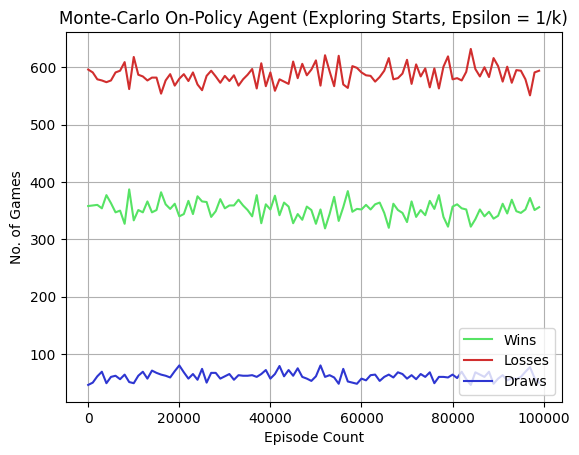

In [ ]:
plot_results(mcop_agent_1_results, "Monte-Carlo On-Policy Agent (Exploring Starts, Epsilon = 1/k)")

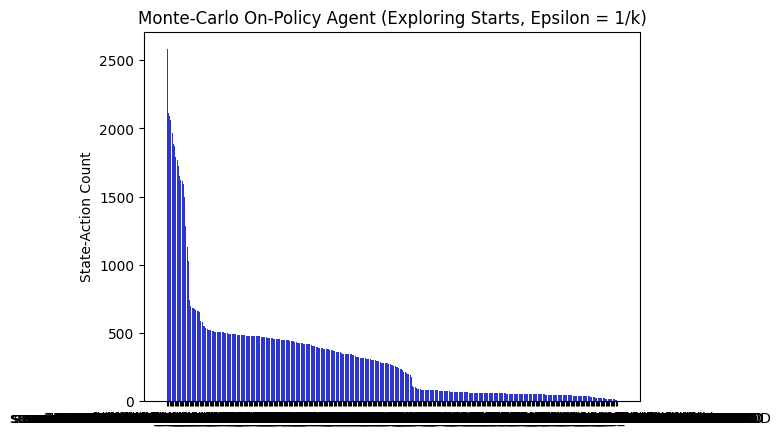

In [ ]:
plot_state_action_counts(mcop_agent_1.n_counter, "Monte-Carlo On-Policy Agent (Exploring Starts, Epsilon = 1/k)")

In [ ]:
import tabulate

strategy_table_mcop_1 = generate_strategy_table(mcop_agent_1, False)

strategy_table_mcop_1 = tabulate.tabulate(strategy_table_mcop_1, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with Exploring Starts and Epsilon = 1 / k (not using ace)")
print(strategy_table_mcop_1)

Strategy Table for Monte Carlo On-Policy Agent with Exploring Starts and Epsilon = 1 / k (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | S   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | S   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | H   | H   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   

In [ ]:
strategy_table_mcop_1 = generate_strategy_table(mcop_agent_1, True)
strategy_table_mcop_1 = tabulate.tabulate(strategy_table_mcop_1, headers=["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with Exploring Starts and Epsilon = 1 / k (using ace)")
print(strategy_table_mcop_1)

Strategy Table for Monte Carlo On-Policy Agent with Exploring Starts and Epsilon = 1 / k (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | S   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | H 

In [ ]:
mcop_agent_2 = MonteCarloOnPolicyAgent(False, 1) # no exploring starts, epsilon is 1/k
mcop_agent_2_simulator = AgentSimulator(mcop_agent_2)
mcop_agent_2_results = mcop_agent_2_simulator.simulate_games(100000)

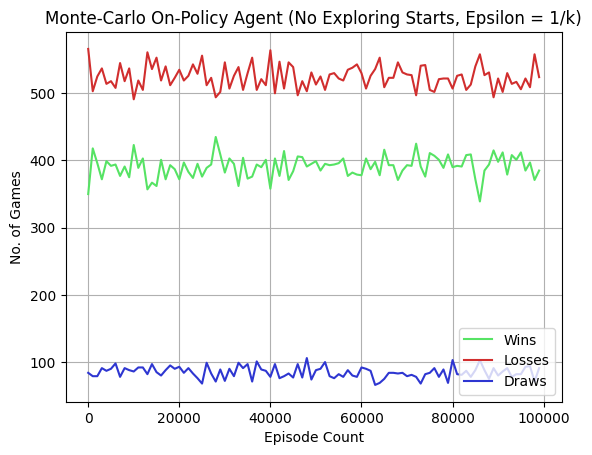

In [ ]:
plot_results(mcop_agent_2_results, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = 1/k)")

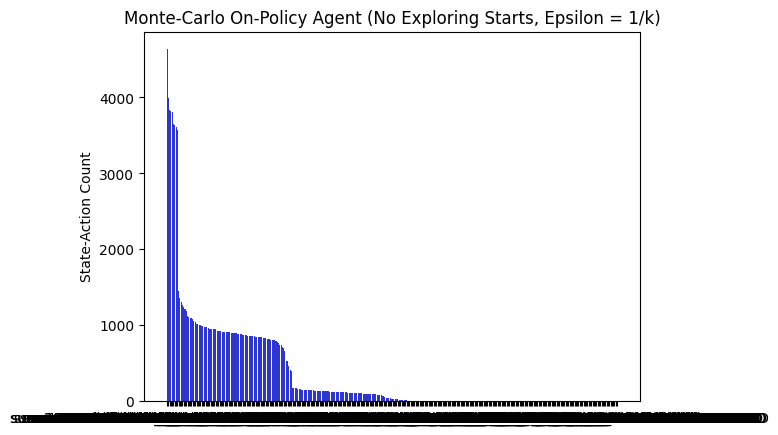

In [ ]:
plot_state_action_counts(mcop_agent_2.n_counter, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = 1/k)")

In [ ]:
strategy_table_mcop_2 = generate_strategy_table(mcop_agent_2, False)

strategy_table_mcop_2 = tabulate.tabulate(strategy_table_mcop_2, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = 1 / k (not using ace)")
print(strategy_table_mcop_2)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = 1 / k (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | S   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | S   | H   | H   | H   | H   | S   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | S   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S

In [ ]:
strategy_table_mcop_2 = generate_strategy_table(mcop_agent_2, True)
strategy_table_mcop_2 = tabulate.tabulate(strategy_table_mcop_2, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = 1 / k (using ace)")
print(strategy_table_mcop_2)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = 1 / k (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | S   | S   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | S   | H   | H   | H   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | H   | S   | S   | H   | H   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   |

In [ ]:
mcop_agent_3 = MonteCarloOnPolicyAgent(False, 2) # no exploring starts, epsilon is e^(-k/1000)
mcop_agent_3_simulator = AgentSimulator(mcop_agent_3)
mcop_agent_3_results = mcop_agent_3_simulator.simulate_games(100000)

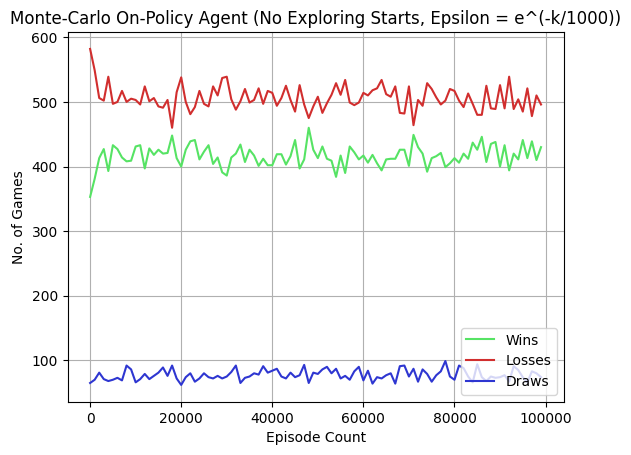

In [ ]:
plot_results(mcop_agent_3_results, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = e^(-k/1000))")

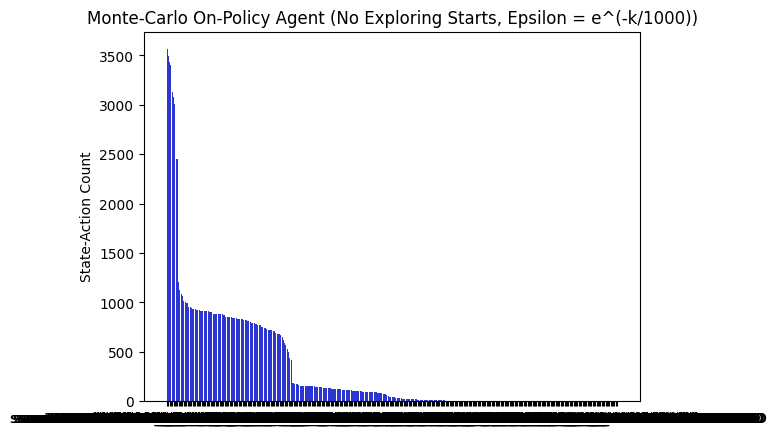

In [ ]:
plot_state_action_counts(mcop_agent_3.n_counter, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = e^(-k/1000))")

In [ ]:
strategy_table_mcop_3 = generate_strategy_table(mcop_agent_3, False)
strategy_table_mcop_3 = tabulate.tabulate(strategy_table_mcop_3, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/1000) (not using ace)")
print(strategy_table_mcop_3)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/1000) (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | S   | H   | H   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | S   | S   | S   | S   | S   | H   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | H   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | H   | H   | H   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | H   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 

In [ ]:
strategy_table_mcop_3 = generate_strategy_table(mcop_agent_3, True)
strategy_table_mcop_3 = tabulate.tabulate(strategy_table_mcop_3, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/1000) (using ace)")
print(strategy_table_mcop_3)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/1000) (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | H   | H   | H   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | H   | H   | H   | H   | H   | H   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | S   | H   | H   | H   | H   | H    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 |

In [ ]:
mcop_agent_4 = MonteCarloOnPolicyAgent(False, 3) # no exploring starts, epsilon is e^(-k/10000)
mcop_agent_4_simulator = AgentSimulator(mcop_agent_4)
mcop_agent_4_results = mcop_agent_4_simulator.simulate_games(100000)

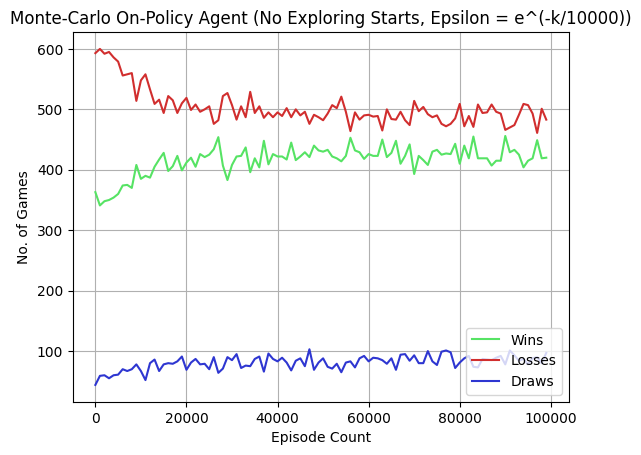

In [ ]:
plot_results(mcop_agent_4_results, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = e^(-k/10000))")

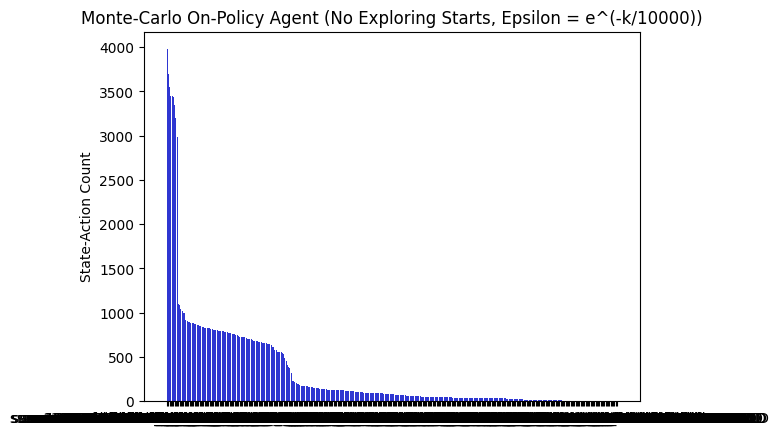

In [ ]:
plot_state_action_counts(mcop_agent_4.n_counter, "Monte-Carlo On-Policy Agent (No Exploring Starts, Epsilon = e^(-k/10000))")

In [ ]:
strategy_table_mcop_4 = generate_strategy_table(mcop_agent_4, False)
strategy_table_mcop_4 = tabulate.tabulate(strategy_table_mcop_4, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/10000) (not using ace)")
print(strategy_table_mcop_4)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/10000) (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | H   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | H   | S   | S   | S   | S   | S   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | H   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | H    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|

In [ ]:
strategy_table_mcop_4 = generate_strategy_table(mcop_agent_4, True)
strategy_table_mcop_4 = tabulate.tabulate(strategy_table_mcop_4, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/10000) (using ace)")
print(strategy_table_mcop_4)

Strategy Table for Monte Carlo On-Policy Agent with No Exploring Starts and Epsilon = e^(-k/10000) (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | H   | H   | H   | S   | H   | H   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | S   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | S   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | S   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | H   | S   | H   | H   | H   | H   | H   | H    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 

Displaying the total number of unique state-action pairs across all configurations for Monte-Carlo On-Policy:

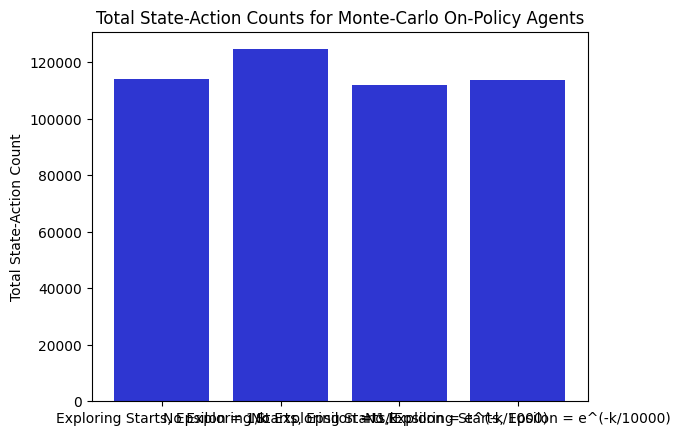

In [ ]:
plot_total_state_action_counts(
    [mcop_agent_1.n_counter, mcop_agent_2.n_counter, mcop_agent_3.n_counter, mcop_agent_4.n_counter], 
    ["Exploring Starts, Epsilon = 1/k", "No Exploring Starts, Epsilon = 1/k", "No Exploring Starts, Epsilon = e^(-k/1000)", "No Exploring Starts, Epsilon = e^(-k/10000)"],
    "Total State-Action Counts for Monte-Carlo On-Policy Agents"
)

In [ ]:
sarsa_agent_1 = SarsaOnPolicyAgent(1) # epsilon is 0.1
sarsa_agent_1_simulator = AgentSimulator(sarsa_agent_1)
sarsa_agent_1_results = sarsa_agent_1_simulator.simulate_games(100000)

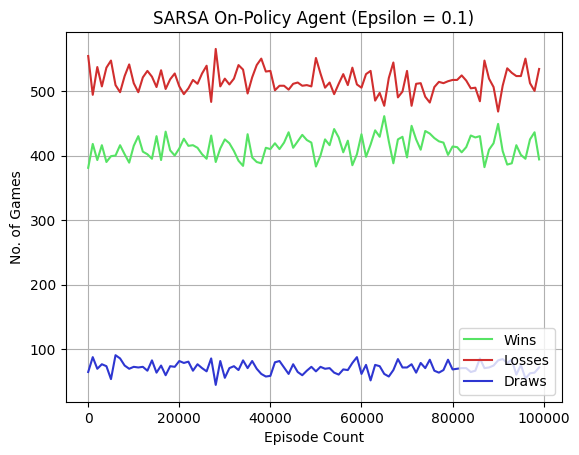

In [ ]:
plot_results(sarsa_agent_1_results, "SARSA On-Policy Agent (Epsilon = 0.1)")

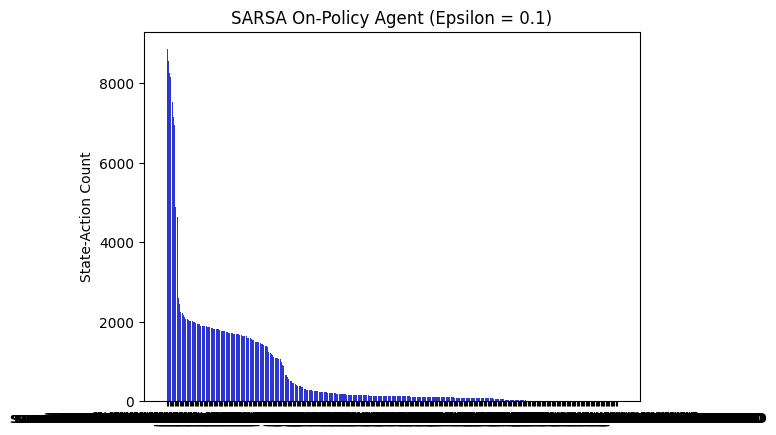

In [ ]:
plot_state_action_counts(sarsa_agent_1.n_counter, "SARSA On-Policy Agent (Epsilon = 0.1)")

In [ ]:
strategy_table_sarsa_1 = generate_strategy_table(sarsa_agent_1, False)
strategy_table_sarsa_1 = tabulate.tabulate(strategy_table_sarsa_1, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = 0.1 (not using ace)")
print(strategy_table_sarsa_1)

Strategy Table for SARSA On-Policy Agent with Epsilon = 0.1 (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | S   | S   | S   | H   | H   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | S   | S   | S   | S   | H   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | S   | H   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | S   | S   | S   | S   | S  

In [ ]:
strategy_table_sarsa_1 = generate_strategy_table(sarsa_agent_1, True)
strategy_table_sarsa_1 = tabulate.tabulate(strategy_table_sarsa_1, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = 0.1 (using ace)")
print(strategy_table_sarsa_1)

Strategy Table for SARSA On-Policy Agent with Epsilon = 0.1 (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | H   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | S   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | S   | S   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | H   | H   | H   | H   | H   | H

In [ ]:
sarsa_agent_2 = SarsaOnPolicyAgent(2) # epsilon is 1/k
sarsa_agent_2_simulator = AgentSimulator(sarsa_agent_2)
sarsa_agent_2_results = sarsa_agent_2_simulator.simulate_games(100000)

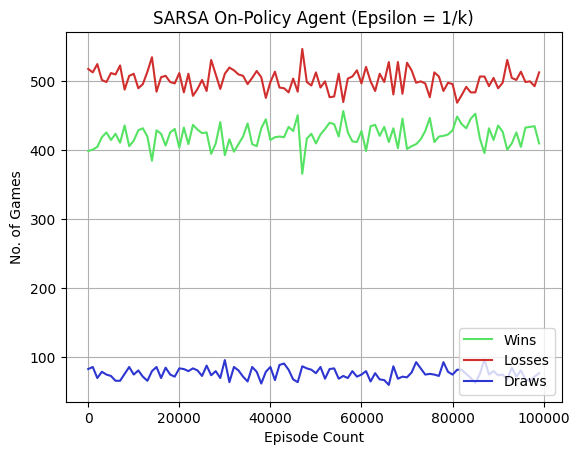

In [ ]:
plot_results(sarsa_agent_2_results, "SARSA On-Policy Agent (Epsilon = 1/k)")

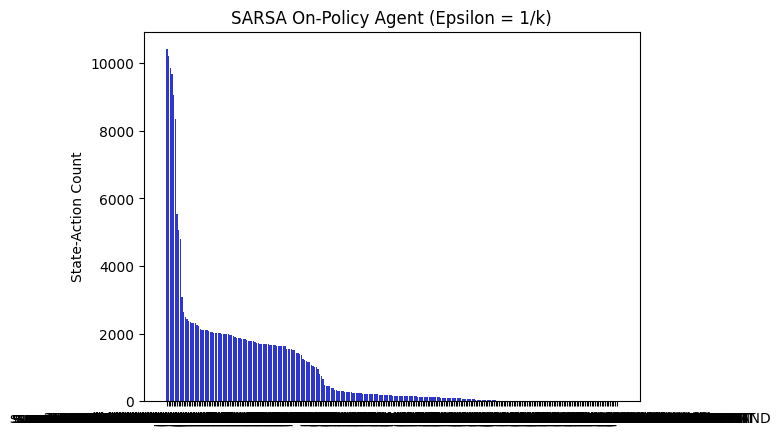

In [ ]:
plot_state_action_counts(sarsa_agent_2.n_counter, "SARSA On-Policy Agent (Epsilon = 1/k)")

In [ ]:
strategy_table_sarsa_2 = generate_strategy_table(sarsa_agent_2, False)
strategy_table_sarsa_2 = tabulate.tabulate(strategy_table_sarsa_2, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = 1/k (not using ace)")
print(strategy_table_sarsa_2)

Strategy Table for SARSA On-Policy Agent with Epsilon = 1/k (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | S   | S   | S   | S   | H   | S   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | S   | S   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | H   | S   | S   | S   | S   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | S   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | S   | S   | S   | S   | S  

In [ ]:
strategy_table_sarsa_2 = generate_strategy_table(sarsa_agent_2, True)
strategy_table_sarsa_2 = tabulate.tabulate(strategy_table_sarsa_2, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = 1/k (using ace)")
print(strategy_table_sarsa_2)

Strategy Table for SARSA On-Policy Agent with Epsilon = 1/k (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | H   | H   | H   | H   | H   | H

In [ ]:
sarsa_agent_3 = SarsaOnPolicyAgent(3) # epsilon is e^(-k/1000)
sarsa_agent_3_simulator = AgentSimulator(sarsa_agent_3)
sarsa_agent_3_results = sarsa_agent_3_simulator.simulate_games(100000)

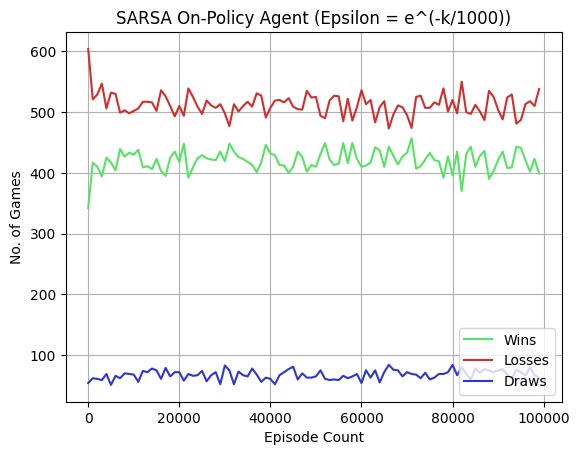

In [ ]:
plot_results(sarsa_agent_3_results, "SARSA On-Policy Agent (Epsilon = e^(-k/1000))")

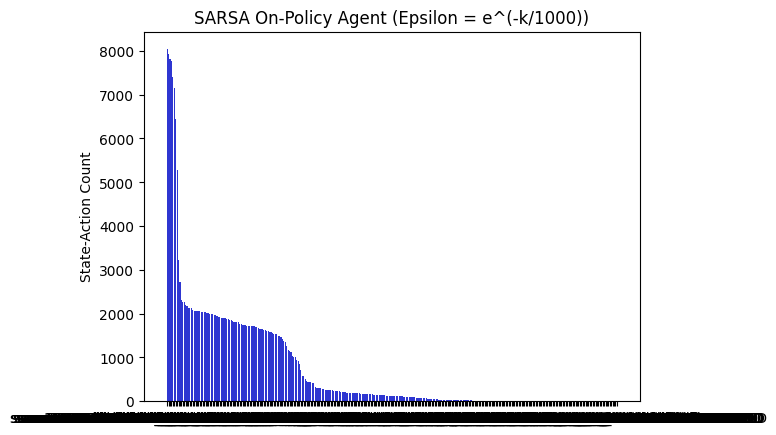

In [ ]:
plot_state_action_counts(sarsa_agent_3.n_counter, "SARSA On-Policy Agent (Epsilon = e^(-k/1000))")

In [ ]:
strategy_table_sarsa_3 = generate_strategy_table(sarsa_agent_3, False)
strategy_table_sarsa_3 = tabulate.tabulate(strategy_table_sarsa_3, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/1000) (not using ace)")
print(strategy_table_sarsa_3)

Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/1000) (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | S   | S   | S   | S   | H   | S   | S   | H    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | S   | H   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | S   | S   | S   | S

In [ ]:
strategy_table_sarsa_3 = generate_strategy_table(sarsa_agent_3, True)
strategy_table_sarsa_3 = tabulate.tabulate(strategy_table_sarsa_3, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/1000) (using ace)")
print(strategy_table_sarsa_3)

Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/1000) (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | H   | S   | S   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | H   | S   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | H   | H   | H   | S   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | S   | H   | H   | H   |

In [ ]:
sarsa_agent_4 = SarsaOnPolicyAgent(4) # epsilon is e^(-k/10000)
sarsa_agent_4_simulator = AgentSimulator(sarsa_agent_4)
sarsa_agent_4_results = sarsa_agent_4_simulator.simulate_games(100000)

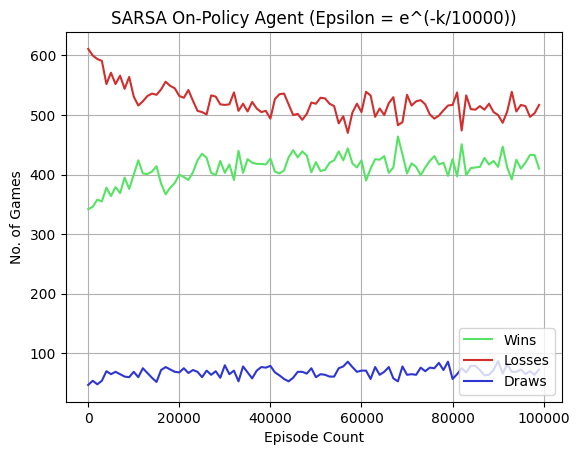

In [ ]:
plot_results(sarsa_agent_4_results, "SARSA On-Policy Agent (Epsilon = e^(-k/10000))")

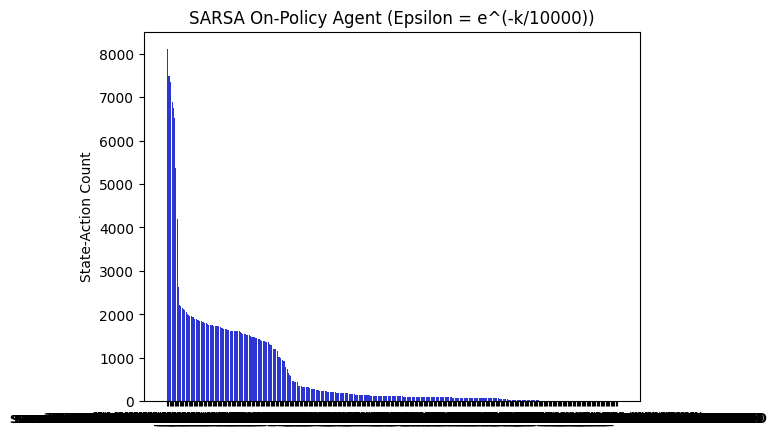

In [ ]:
plot_state_action_counts(sarsa_agent_4.n_counter, "SARSA On-Policy Agent (Epsilon = e^(-k/10000))")

In [ ]:
strategy_table_sarsa_4 = generate_strategy_table(sarsa_agent_4, False)
strategy_table_sarsa_4 = tabulate.tabulate(strategy_table_sarsa_4, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/10000) (not using ace)")
print(strategy_table_sarsa_4)

Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/10000) (not using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | S   | S   | S   | S   | S   | S   | S   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | S   | S   | S   | S   | S   | S   | S   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | S   | S   | S   | S   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | S   | S   | S   | S   | S   | S   | S   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | S   | S   | S   | S   | 

In [ ]:
strategy_table_sarsa_4 = generate_strategy_table(sarsa_agent_4, True)
strategy_table_sarsa_4 = tabulate.tabulate(strategy_table_sarsa_4, headers = ["", "2", "3", "4", "5", "6", "7", "8", "9", "10", "A"], tablefmt = "grid")

print("Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/10000) (using ace)")
print(strategy_table_sarsa_4)

Strategy Table for SARSA On-Policy Agent with Epsilon = e^(-k/10000) (using ace)
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
+====+=====+=====+=====+=====+=====+=====+=====+=====+======+=====+
| 12 | H   | S   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 13 | S   | H   | H   | S   | H   | H   | S   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 14 | S   | S   | S   | H   | S   | H   | H   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | S    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 16 | H   | H   | S   | H   | S   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
| 17 | H   | H   | H   | H   | H   

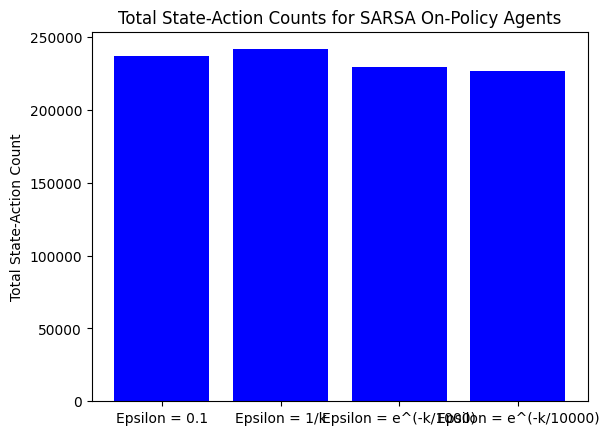

In [ ]:
plot_total_state_action_counts([sarsa_agent_1.n_counter, sarsa_agent_2.n_counter, sarsa_agent_3.n_counter, sarsa_agent_4.n_counter], ["Epsilon = 0.1", "Epsilon = 1/k", "Epsilon = e^(-k/1000)", "Epsilon = e^(-k/10000)"], "Total State-Action Counts for SARSA On-Policy Agents")